## フリークエント・カテゴリー・インピュテーション｜モード・インピュテーション

インピュテーションとは，欠落しているデータを統計的な推定値で置き換えることである．置換技術の目的は，機械学習モデルの学習に使用できる**完全なデータセット**を作成することである．

モードインピュテーションは、変数内のすべての欠損値（NA）をモード（言い換えれば、**最も頻度の高い値**または**最も頻度の高いカテゴリー**）で置き換えることです。


### 最頻値/モードインピュテーションでインピュートできる変数は？

最頻値は、数値変数でもカテゴリー変数でも計算することができますが、実際には、カテゴリー変数でのみ使用します。その理由は、数値変数の場合は、平均値や中央値の方が母集団の平均値を表す傾向があるからです。


### 前提条件

- データは完全に無作為に欠損している (MCAR)
- 欠損したオブザベーションは、ほとんどの場合、その変数のオブザベーションの大部分のように見える（別名、最頻値）。

欠損したオブザベーションの値は、その変数の中で最も頻度の高い値やカテゴリーである可能性が高いという根拠があります。


### メリット

- 実装が簡単
- 完全なデータセットを迅速に得ることができる
- 本番環境（モデル導入時）でも利用可能


### 制限事項

- データセット内の他の変数と最頻値ラベルの関係が歪む。
- NAの数が多い場合、最頻値ラベルが過剰に表示される可能性がある


### 最頻値/最頻値カテゴリの推定を使用する場合は？

- データが完全に無作為に欠損している
- 変数の5%以上が欠損していない場合

## このデモでは

House Pricesのデータセットを使って、カテゴリー変数の最頻値帰納の方法をデモします。

- データセットをダウンロードするには、このコースの**セクション1**にある**データセット**の講義を参照してください。


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# データセットを分割する
from sklearn.model_selection import train_test_split

### 住宅価格データセット

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# デモのためにデータセットにいくつかのカラムをロードしてみましょう。

# これらはカテゴライズされたカラムであり、ターゲットであるSalePrice
cols_to_use = ['BsmtQual', 'FireplaceQu', 'SalePrice']

data = pd.read_csv('/content/drive/MyDrive/特徴量工学/Section-04-Missing-Data-Imputation/HousePrice.csv', usecols=cols_to_use)
data.head()

,BsmtQual,FireplaceQu,SalePrice
0,Gd,NaN,208500
1,Gd,TA,181500
2,Gd,TA,223500
3,TA,Gd,140000
4,Gd,TA,250000


In [4]:
# 各変数の欠損値の割合を調べてみよう

data.isnull().mean()

BsmtQual       0.025342
FireplaceQu    0.472603
SalePrice      0.000000
dtype: float64

変数BsmtQualは、NA（2.5）を持つわずかなオブザベーションを含んでおり、したがって、これらのオブザベーションを最も頻繁なカテゴリの値で置き換えることは、良いアプローチです。

一方、変数FireplaceQuは、オブザベーションのほぼ半分に欠損データを含んでいます。そのため、それらを最も頻度の高いカテゴリーに置き換えると、最も頻度の高いカテゴリーと販売価格の関係が歪んでしまう可能性が高いです。

さらに、もしFireplaceQuの多くのオブザベーションが欠落しているなら、それは理由があってのことであり、単なるランダムではないかもしれません。次のノートでその方法を見てみましょう。今のところ、欠損データが少ないか多い場合に、NAを最も頻度の高いカテゴリで置き換える効果を調べてみましょう。



### インピュテーションの重要性

インピュテーションはトレーニングセットで行われ、テストセットに伝搬されます。つまり、トレーニングセットから最も頻度の高いカテゴリを選択し、トレーニングセットとテストセットの両方でNAを置き換えるために使用する必要があります。


In [5]:

# トレーニングセットとテストセットに分けよう

X_train, X_test, y_train, y_test = train_test_split(
    data,
    data['SalePrice'], # ターゲット
    test_size=0.3, # テストセットに含まれるオブザベーションの割合
    random_state=0) # 再現性のための種

X_train.shape, X_test.shape

((1022, 3), (438, 3))

#### BsmtQual

In [6]:
# 欠損値の%を思い出してみよう
X_train['BsmtQual'].isnull().mean()

0.023483365949119372

Text(0, 0.5, 'Number of houses')

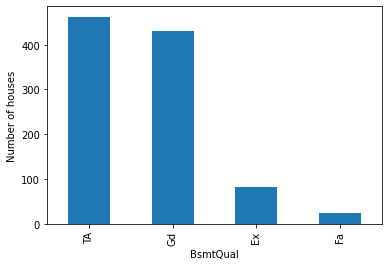

In [7]:
# BsmtQualのカテゴリごとのオブザベーションの数を調べてみましょう。

# セクション3の変数の特徴では、このコードを使用しました。

# value_counts()は、以下に示す変数の各ラベルを表示している家の数をカウントします。
# 以下に示す変数で


X_train['BsmtQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('BsmtQual')
plt.ylabel('Number of houses')

In [9]:
# BsmtQualの最も頻度の高いカテゴリーを見つけよう

X_train['BsmtQual'].mode()

0    TA
dtype: object

Text(0.5, 1.0, 'BsmtQual')

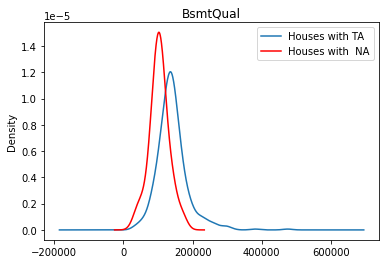

In [11]:

# 最も頻度の高いカテゴリーを見つけよう ==> # その家のターゲットの分布をプロットしてみよう

# * 最も頻度の高いカテゴリーを示すもの、または
# * 欠落しているデータがある場合

fig = plt.figure()
ax = fig.add_subplot(111)

# 最も頻度の高いラベルを持つ家を選択し，プロットする
X_train[X_train['BsmtQual']=='TA']['SalePrice'].plot(kind='kde', ax=ax)

# 変数に欠損データがある住宅を選択してプロットする
X_train[X_train['BsmtQual'].isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')

# 凡例の追加
lines, labels = ax.get_legend_handles_labels()
labels = ['Houses with TA', 'Houses with  NA']
ax.legend(lines, labels, loc='best')

# 図のタイトルを追加
plt.title('BsmtQual')



上のプロットでは、データが欠落している住宅は、ラベルがTAの住宅よりも全体的にコストが低いことがわかります。したがって、欠損値をTAに置き換えることで、NAが多い場合は全体の分布に影響を与える可能性があります。



In [12]:

# 最も頻度の高いカテゴリーのSalePriceの元の分布を後のために残しておきます。
# の元の分布を保持します。

# tmpの使用は、一時的な変数に名前を付ける際によく使われます。


tmp = X_train[X_train['BsmtQual']=='TA']['SalePrice']

In [13]:

# trainとtestの両方でnaを埋めよう

# pandasのfillna()メソッドを使用します。

# pandasのfillna()メソッドを使用します , inplace=Trueの引数で、pandasに
# 同じデータセット内で値を置き換えたいことを示す


X_train['BsmtQual'].fillna('TA', inplace=True)
X_test['BsmtQual'].fillna('TA', inplace=True)

In [14]:
# NAが満たされているかチェックしよう

X_train['BsmtQual'].isnull().sum()

0

Text(0, 0.5, 'Number of houses')

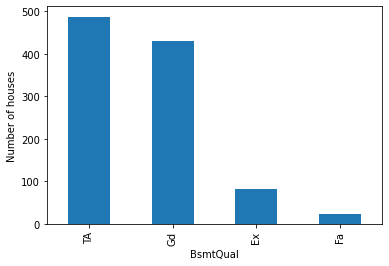

In [15]:
# evaluate effect on distribution of categories

X_train['BsmtQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('BsmtQual')
plt.ylabel('Number of houses')

上のプロットから、以前はNAを含んでいたTAというラベルの家が少し増えていることがわかりますが、分布に対する全体的な効果は劇的ではありません。このプロットは、インピュテーションを行う前のものとほとんど同じです。

Text(0.5, 1.0, 'FirePlaceQu')

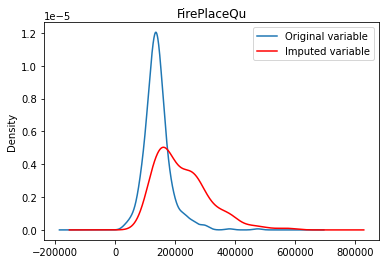

In [16]:

# 元の変数に対するターゲットの分布をプロットしよう
# 入力された変数と

fig = plt.figure()
ax = fig.add_subplot(111)

# 元の変数の分布
# ノートブックの数セル上でこれをキャプチャしたことを思い出してください
tmp.plot(kind='kde', ax=ax)

# インピュテーション後の変数の分布
X_train[X_train['FireplaceQu'] == 'Gd']['SalePrice'].plot(
    kind='kde', ax=ax, color='red')

# 凡例の追加
lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

plt.title('FirePlaceQu')


欠損データの数が少なかったため，元の変数と入力された変数の住宅価格の分布はよく似ています．このような挙動を期待していました。

欠損データの割合が高い場合のモードインピュテーションの効果を調べてみましょう。

#### FirePlaceQu

In [17]:
# 欠損値の割合を思い出してみよう
X_train['FireplaceQu'].isnull().mean()

0.46771037181996084

Text(0, 0.5, 'Number of houses')

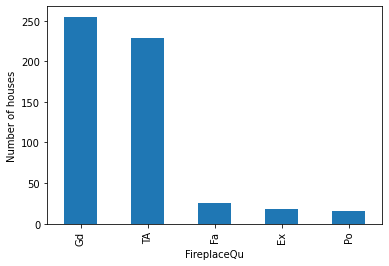

In [18]:
# let's inspect the number of observations per category

X_train['FireplaceQu'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('FireplaceQu')
plt.ylabel('Number of houses')

In [19]:
# FirePlaceQuの最も頻度の高いカテゴリーを見つけよう

X_train['FireplaceQu'].mode()

0    Gd
dtype: object

Text(0.5, 1.0, 'FirePlaceQu')

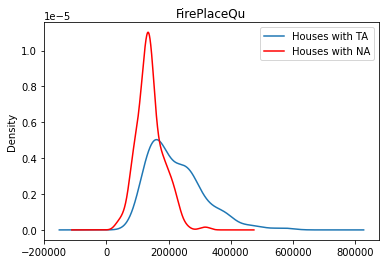

In [20]:

# 最も頻度の高いカテゴリーを示した家と、欠損値を示した家のターゲットの分布をプロットしてみよう。
# 最も頻度の高いカテゴリーを示すものと、欠測値を示すものについて

fig = plt.figure()
ax = fig.add_subplot(111)

# FirePlaceQuのラベルが最も頻繁に表示される家
X_train[X_train['FireplaceQu']=='Gd']['SalePrice'].plot(kind='kde', ax=ax)

# FirePlaceQuにデータがない家
X_train[X_train['FireplaceQu'].isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')

# 凡例の追加
lines, labels = ax.get_legend_handles_labels()
labels = ['Houses with TA', 'Houses with NA']
ax.legend(lines, labels, loc='best')

plt.title('FirePlaceQu')



分布はかなり異なっており、データ欠損のある家は、ラベルがGdの家よりも全体的にコストが低いことがわかります。


In [21]:

# FirePlaceQuでGdと表示された住宅のSalePriceの分布を元のままにします。
# FirePlaceQuでGdと表示された家のSalePriceの元の分布を後に残しておきます。


tmp = X_train[X_train['FireplaceQu']=='Gd']['SalePrice']

In [22]:
# trainとtestの両方でnaを埋めてみよう

X_train['FireplaceQu'].fillna('Gd', inplace=True)
X_test['FireplaceQu'].fillna('Gd', inplace=True)

Text(0, 0.5, 'Number of houses')

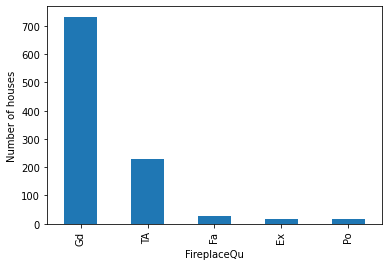

In [23]:
# カテゴリごとの観測数を調べてみよう

X_train['FireplaceQu'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('FireplaceQu')
plt.ylabel('Number of houses')

このケースでは、変数の元の分布に大きな歪みが見られます。変数Gdを含む家が、他の変数を含む家よりも多くなっています。元々、FirePlaceQuの観測値の半分が欠けていました。今では、それらの値のすべてにGdが含まれています。そのため、棒グラフではGdが大きく増加しています。


Text(0.5, 1.0, 'FirePlaceQu')

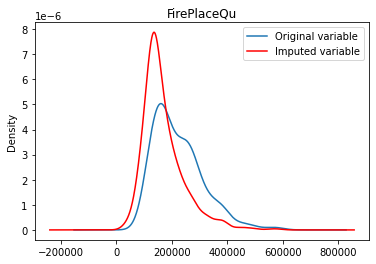

In [24]:
# 元の変数のターゲットの分布をプロットしましょう
#と入力された変数のターゲットの分布をプロットしてみましょう

fig = plt.figure()
ax = fig.add_subplot(111)

# 元の変数の分布
# ノートブックの数セル上でこれをキャプチャしたことを思い出してください
tmp.plot(kind='kde', ax=ax)

# インピュテーション後の変数の分布
X_train[X_train['FireplaceQu'] == 'Gd']['SalePrice'].plot(
    kind='kde', ax=ax, color='red')

# 凡例の追加
lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

plt.title('FirePlaceQu')


最も頻度の高いカテゴリーの平均ハウス値は、NAを最も頻度の高いラベルとして再分類した後、NAのハウス値を加えた後、かなり劇的に減少しています。

このように、このラベルの住宅価格予測に対する重要性が、欠損値の追加によって覆い隠されたり、変化したりしています。

このようなケースでは、欠損値の割合が非常に高い場合（～50％）、NAでオブザベーションを囲むために新しいカテゴリを作成する方が良いでしょう。これは次回の講義で紹介します。



**今回のデモはここまでです。後のセクションでは、機械学習パイプラインの一部としてscikit-learnとfeature engineでモードインピュテーションを行う方法を紹介します。
